This script visualises gene expression patterns responding to two-factor influences.

In [1]:
import pandas, numpy

In [2]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':30, 'ytick.labelsize':30, 'figure.figsize':(16, 9), 'axes.labelsize':40})

# 0. user-defined variables

In [3]:
expression_file = '/home/adrian/projects/nautholsvik/results/tpm/DESeq2_TPM_values.tsv'
significance_dir = '/home/adrian/projects/nautholsvik/results/DEGs_DESeq2/'

In [4]:
genotypes = ['WT', 'siCTRL', 'siMITF']
treatments = ['wo_IFN', 'with_IFN']

# 1. read and manipulate expression data

In [5]:
expression_with_replicates = pandas.read_csv(expression_file, sep='\t', index_col=0)
log2_expression_with_replicates = numpy.log2(expression_with_replicates + 1)

In [6]:
log2_expression = pandas.DataFrame()
replicate_labels = log2_expression_with_replicates.columns

for genotype in genotypes:
    for treatment in treatments:
        new_label = genotype + '_' + treatment
        sub = [label for label in replicate_labels if genotype in label and treatment in label]
        df = log2_expression_with_replicates[sub]
        log2_expression[new_label] = df.median(axis=1)

log2_expression.head()

,WT_wo_IFN,WT_with_IFN,siCTRL_wo_IFN,siCTRL_with_IFN,siMITF_wo_IFN,siMITF_with_IFN
ENSG00000000003,4.610293,4.704804,4.692929,4.573542,4.643634,4.622862
ENSG00000000005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000000419,7.210053,7.286494,7.227183,7.177744,7.327914,7.300795
ENSG00000000457,2.790064,3.242687,2.894178,3.409461,3.362578,3.681743
ENSG00000000460,5.539515,5.337610,5.444717,5.084886,5.100436,4.540690


# 2. create a dataframe ready for plotting

This dataframe should have x, y, and transitions, significance of x and y, significance of influence, significance of transition and average expression.

In [7]:
plotting_df = pandas.DataFrame()

In [8]:
labels = [label for label in log2_expression.columns if 'WT' not in label]
plotting_df['average_expression'] = log2_expression[labels].mean(axis=1)
plotting_df['max_expression'] = log2_expression[labels].max(axis=1)

In [9]:
# define x, y and z as for transitions
plotting_df['A1A0'] = log2_expression['siCTRL_with_IFN'] - log2_expression['siCTRL_wo_IFN']
plotting_df['B1B0'] = log2_expression['siMITF_with_IFN'] - log2_expression['siMITF_wo_IFN']
plotting_df['B0A0'] = log2_expression['siMITF_wo_IFN'] - log2_expression['siCTRL_wo_IFN']

plotting_df.head()

,average_expression,max_expression,A1A0,B1B0,B0A0
ENSG00000000003,4.633242,4.692929,-0.119387,-0.020772,-0.049295
ENSG00000000005,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000000419,7.258409,7.327914,-0.049439,-0.027119,0.100731
ENSG00000000457,3.336990,3.681743,0.515283,0.319164,0.468401
ENSG00000000460,5.042682,5.444717,-0.359831,-0.559746,-0.344281


# 3. read significances

In [10]:
# read signifcances
df = pandas.read_csv(significance_dir+'A0_A1_transition.tsv', sep='\t', index_col=0)
plotting_df['P_A1A0'] = df['padj']

df = pandas.read_csv(significance_dir+'B0_B1_transition.tsv', sep='\t', index_col=0)
plotting_df['P_B1B0'] = df['padj']

df = pandas.read_csv(significance_dir+'A0_B0_transition.tsv', sep='\t', index_col=0)
plotting_df['P_B0A0'] = df['padj']

df = pandas.read_csv(significance_dir+'interaction.tsv', sep='\t', index_col=0)
plotting_df['P_interaction'] = df['padj']

In [11]:
plotting_df.fillna(1, inplace=True)

In [13]:
# remove low-expression genes: less than two tpm
print(plotting_df.shape)
plotting_df.drop(plotting_df[plotting_df['max_expression'] < numpy.log2(2+1)].index, inplace=True)
print(plotting_df.shape)

(40173, 9)
(12742, 9)


In [14]:
plotting_df.head()

,average_expression,max_expression,A1A0,B1B0,B0A0,P_A1A0,P_B1B0,P_B0A0,P_interaction
ENSG00000000003,4.633242,4.692929,-0.119387,-0.020772,-0.049295,1.000000e+00,1.000000e+00,1.000000,1.000000e+00
ENSG00000000419,7.258409,7.327914,-0.049439,-0.027119,0.100731,1.000000e+00,1.000000e+00,1.000000,1.000000e+00
ENSG00000000457,3.336990,3.681743,0.515283,0.319164,0.468401,1.000000e+00,1.000000e+00,1.000000,1.000000e+00
ENSG00000000460,5.042682,5.444717,-0.359831,-0.559746,-0.344281,1.000000e+00,1.000000e+00,1.000000,1.000000e+00
ENSG00000000971,1.450129,3.382358,1.352847,3.209656,-0.273603,4.909581e-46,6.452543e-17,0.003251,3.700648e-16


In [15]:
print(sum(plotting_df['P_A1A0'] < 0.1))
print(sum(plotting_df['P_B1B0'] < 0.1))
print(sum(plotting_df['P_B0A0'] < 0.1))
print(sum(plotting_df['P_interaction'] < 0.1))

467
507
1052
631


In [16]:
# check if MITF is A0 to B0 transition
print('ENSG00000187098' in plotting_df[plotting_df['P_B0A0'] < 0.1].index)

# check if PD-L1 is a gene with significant interaction
print('ENSG00000120217' in plotting_df[plotting_df['P_interaction'] < 0.1].index)

True
True


# 3. plot

In [17]:
# select genes that will be plotted
rules = (plotting_df['P_A1A0'] < 0.1) | (plotting_df['P_B1B0'] < 0.1) | (plotting_df['P_interaction'] < 0.1)
scatter_df = plotting_df[rules]
scatter_df.shape

(1030, 9)

In [18]:
scatter_df

,average_expression,max_expression,A1A0,B1B0,B0A0,P_A1A0,P_B1B0,P_B0A0,P_interaction
ENSG00000000971,1.450129,3.382358,1.352847,3.209656,-0.273603,4.909581e-46,6.452543e-17,3.251351e-03,3.700648e-16
ENSG00000001617,2.530528,4.237296,1.934280,3.343321,-0.634306,2.693530e-60,2.163420e-165,1.073405e-08,6.015352e-14
ENSG00000002549,7.277011,8.620094,1.800322,2.502722,-0.167754,1.209158e-84,5.435859e-202,1.000000e+00,2.649351e-07
ENSG00000003056,7.643805,7.966329,-0.027627,0.178039,-0.720254,1.000000e+00,1.000000e+00,1.000000e+00,2.131673e-02
ENSG00000004487,6.929774,7.772294,0.837383,-0.052097,-0.402918,1.000000e+00,1.000000e+00,1.000000e+00,3.064888e-27
...,...,...,...,...,...,...,...,...,...
ENSG00000285417,2.369644,2.934850,0.676430,0.995775,-0.025035,1.000000e+00,1.378931e-04,1.000000e+00,1.000000e+00
ENSG00000285485,3.683206,4.011724,0.375752,-0.087283,0.801271,1.000000e+00,1.000000e+00,1.000000e+00,8.995258e-02
ENSG00000285566,3.001435,3.525255,0.855002,0.854446,0.193471,1.000000e+00,1.873049e-09,1.000000e+00,1.000000e+00
ENSG00000285942,1.667538,1.991441,0.094384,0.349174,-0.680817,1.000000e+00,1.000000e+00,2.176589e-14,7.264890e-02


In [58]:
print(numpy.max(scatter_df['A1A0']))
print(numpy.min(scatter_df['A1A0']))

print(numpy.max(scatter_df['B1B0']))
print(numpy.min(scatter_df['B1B0']))

top = 8.88902963726265
bottom = -1.714038627059151 

8.084180132075929
-1.5025516325277113
8.88902963726265
-1.714038627059151


1.9065063528762167 3.237379195787593


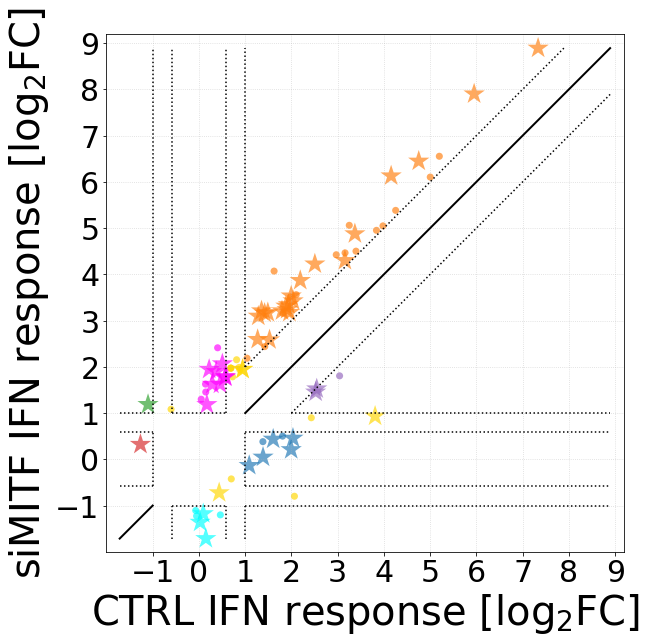

In [73]:
def color_definer(x, y):
    the_color = None
    if x < -1:
        if y > 1:
            the_color = 'tab:green'
        else:
            the_color = 'tab:red'
    elif -1 < x < -numpy.log2(1.5) or numpy.log2(1.5) < x < 1:
        the_color = 'gold'
    elif -numpy.log2(1.5) < x < numpy.log2(1.5):
        if y > 1:
            the_color = 'magenta'
        elif y < -1:
            the_color = 'cyan'
        else:
            the_color = 'gold'
    elif x > 1:
        if y > x:
            the_color = 'tab:orange'
        else:
            if y > 1:
                the_color = 'tab:purple'
            elif -numpy.log2(1.5) < y < numpy.log2(1.5):
                the_color = 'tab:blue'
            else:
                the_color = 'gold'
    else:
        print('ERROR')
    
    return the_color

for ensembl in scatter_df.index:
    x = scatter_df.loc[ensembl, 'A1A0']
    y = scatter_df.loc[ensembl, 'B1B0']
    
    if ensembl == 'ENSG00000120217': # PD-L1
        print(x, y)
    
    if scatter_df.loc[ensembl, 'P_interaction'] < 0.1:
        the_marker = '*'
        the_size = 500
    else:
        the_marker = '.'
        the_size = 200
    
    if numpy.abs(x-y) >= 1:        
        the_color = color_definer(x, y)
        matplotlib.pyplot.scatter(x, y, s=the_size, c=the_color, alpha=2/3, marker=the_marker, edgecolors='none')

# middle lines
matplotlib.pyplot.plot([1, top], [1, top], color='black', lw=2)
matplotlib.pyplot.plot([bottom, -1], [bottom, -1], color='black', lw=2)
# positive synergy
matplotlib.pyplot.plot([1, top-1], [1+1, top], color='black', ls=':')
matplotlib.pyplot.vlines(1, ymin=2, ymax=top, color='black', ls=':')
# magenta borders
matplotlib.pyplot.vlines(numpy.log2(1.5), ymin=1, ymax=top, color='black', ls=':')
matplotlib.pyplot.vlines(-numpy.log2(1.5), ymin=1, ymax=top, color='black', ls=':')
matplotlib.pyplot.hlines(1, xmin=-numpy.log2(1.5), xmax=numpy.log2(1.5), color='black', ls=':')
# cyan borders
matplotlib.pyplot.vlines(numpy.log2(1.5), ymin=bottom, ymax=-1, color='black', ls=':')
matplotlib.pyplot.vlines(-numpy.log2(1.5), ymin=bottom, ymax=-1, color='black', ls=':')
matplotlib.pyplot.hlines(-1, xmin=-numpy.log2(1.5), xmax=numpy.log2(1.5), color='black', ls=':')
# blue borders
matplotlib.pyplot.hlines(numpy.log2(1.5), xmin=1, xmax=top, color='black', ls=':')
matplotlib.pyplot.hlines(-numpy.log2(1.5), xmin=1, xmax=top, color='black', ls=':')
matplotlib.pyplot.vlines(1, ymin=-numpy.log2(1.5), ymax=numpy.log2(1.5), color='black', ls=':')
# flipped lower corner
matplotlib.pyplot.hlines(-1, xmin=1, xmax=top, color='black', ls=':')
matplotlib.pyplot.vlines(1, ymin=bottom, ymax=-1, color='black', ls=':')
# flipped upper corner
matplotlib.pyplot.hlines(1, xmin=bottom, xmax=-1, color='black', ls=':')
matplotlib.pyplot.vlines(-1, ymin=1, ymax=top, color='black', ls=':')
# positive antagonism
matplotlib.pyplot.plot([2, top], [1, top-1], color='black', ls=':')
matplotlib.pyplot.hlines(1, xmin=2, xmax=top, color='black', ls=':')
# new red quadrand
matplotlib.pyplot.hlines(numpy.log2(1.5), xmin=bottom, xmax=-1, color='black', ls=':')
matplotlib.pyplot.hlines(-numpy.log2(1.5), xmin=bottom, xmax=-1, color='black', ls=':')
matplotlib.pyplot.vlines(-1, ymin=-numpy.log2(1.5), ymax=numpy.log2(1.5), color='black', ls=':')

matplotlib.pyplot.xlim([-2, 9.2])
matplotlib.pyplot.ylim([-2, 9.2])

matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('CTRL IFN response [log$_2$FC]')
matplotlib.pyplot.ylabel('siMITF IFN response [log$_2$FC]')
matplotlib.pyplot.gca().set_aspect('equal', 'box')

matplotlib.pyplot.xticks([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
matplotlib.pyplot.yticks([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

matplotlib.pyplot.tight_layout()

In [21]:
#TODO


# print the genes
# consider plotting some  names
# legend with synergy names
# repeat the plot with size as average expression and color as fc of A0 to B0. 
# plot all cases in expression coordinates to check patterns are evident

In [ ]:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4395182/ for nomenclature

- purple: positive antagonistic
- orange: positive synergistic 
    